In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

# Define Simulation Functions

We skip the description as they are the same as in the Pairwise Simulation and Center Simulation notebooks.

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

In [3]:
def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

## Define Simulation

First, our metric is the total KL divergence between mapped spots. In our simulation, we have it set up such that the ith spot in layer A maps to the ith spot in layer B, so our calculation is sum of KL divergence between all ith rows in gene expression matrices X and Y.

In [4]:
from scipy.stats import entropy

# Ignores 0s
def kl_divergence(X, Y):
    assert X.shape == Y.shape, "X and Y have different dimensions."
    X = X/X.sum(axis=1, keepdims=True)
    Y = Y/Y.sum(axis=1, keepdims=True)
    s = 0

    c = np.true_divide(X,Y)
    c = np.log(c)
    c = np.nan_to_num(c, neginf=0, posinf = 0)

    return np.sum(np.multiply(X, c))

# alternate kl divergence that adds pseudocount to avoid dividing by 0
def kl_divergence2 (X, Y):
    assert X.shape == Y.shape, "X and Y have different dimensions."
    X += 0.01
    Y += 0.01
    s = 0
    for i in range(X.shape[0]):
        e = entropy(X[i], Y[i])
        if not np.isinf(e):
            s += e 
    return s

Next, given a layer, we simulate three layers. Then, we infer a center layer using PASTE. For Scanorama, we integrated all three layers. Finally we calculate the KL divergence between the original layer and the inferred layer. For Scanorama, we calculate the KL divergence between the original layer and each of the integrated layers and take the average of the three.

In [5]:
def scanorama_sim(base_layer, sim_layers, maps):
    b = base_layer.copy()
    corrected = scanorama.correct_scanpy(sim_layers)
    
    genes = corrected[0].var_names
    b = b[:, genes]
    kl_score = []

    for c, m in zip(corrected, maps):
        X = b.X[m][:]
        Y = scipy.sparse.csc_matrix.toarray(c.X) + abs(np.min(scipy.sparse.csc_matrix.toarray(c.X)))
        kl_score.append(kl_divergence(X, Y))
    return kl_score

def paste_sim(base_layer, sim_layers, maps, alpha = 0.1, pc = 1):
    true_layer = base_layer.copy()
    lmbda = len(sim_layers)*[1/len(sim_layers)]
    base_layer = simulate_gene_exp(base_layer, pc = pc)
    center_slice, pis = paste.center_align(base_layer, sim_layers, lmbda, alpha = alpha, n_components= 15)
    
    kl_score = kl_divergence(true_layer[center_slice.obs_names, :].X, center_slice.X)
    return kl_score

def sim(base_layer, pc, alpha):
    base_layer = base_layer.copy()
    # the following block of code is if you want your initial layer to be low dimensional
    model = NMF(n_components=15, solver = 'mu', init='random', beta_loss = 'kullback-leibler')
    W = model.fit_transform(base_layer.X)
    H = model.components_
    base_layer.X = pd.DataFrame(np.dot(W, H))
    sim_layers = []
    maps = []
    theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
    for i in range(3):
        adata_layer_sim_spatial, mappings = simulate_spatial(base_layer, theta_angles[i])
        adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = pc)
        sim_layers.append(adata_layer_sim_both)
        maps.append(mappings)
    
    scanorama_diff = scanorama_sim(base_layer, sim_layers, maps)
    scanorama_diff = np.mean(scanorama_diff)
    
    paste_diff = paste_sim(base_layer, sim_layers, maps, alpha, pc)
    
    return scanorama_diff, paste_diff

# Run Simulation

## Read in data

In [6]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [7]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"
adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

## Generate Results

In [8]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

In [9]:
path_to_output_dir = '../data/Stahl-BC/cached-results/center-sim/scanorama-comparison/'

if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)

In [10]:
# Number of runs per experiment
N_RUNS = 10
pseudocounts = [0.1, 1, 2, 3, 4, 5]

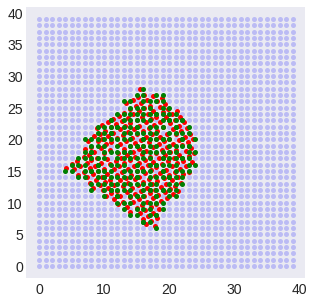

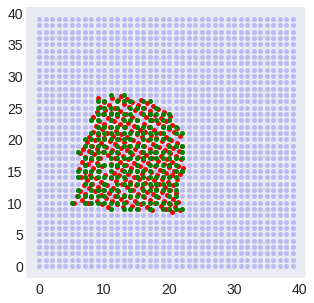

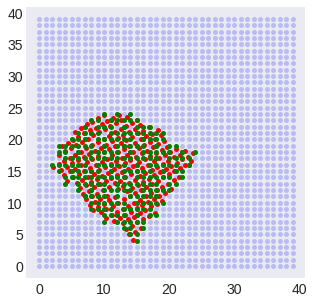

Found 14880 genes among all datasets
[[0.         0.80454545 0.77727273]
 [0.         0.         0.83181818]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6165282650586321

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12505845580855213

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005372911408184411

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0011314053921240852

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004538929325854646



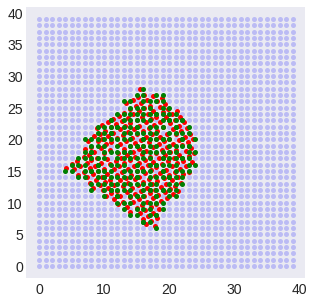

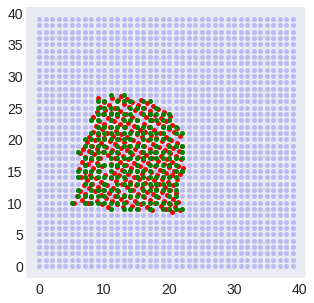

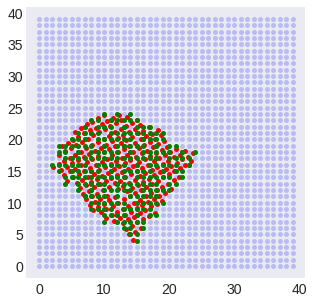

Found 14880 genes among all datasets
[[0.         0.82727273 0.83636364]
 [0.         0.         0.85      ]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.43474634699007275

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



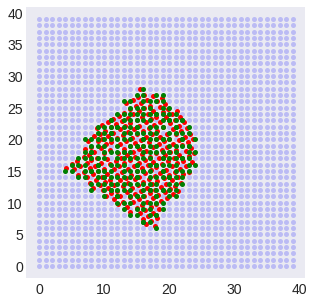

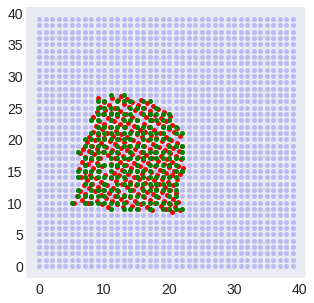

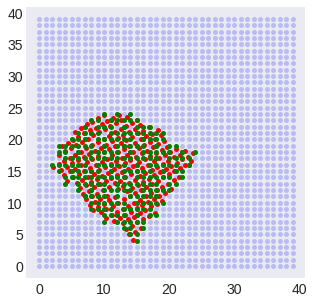

Found 14880 genes among all datasets
[[0.         0.85454545 0.77727273]
 [0.         0.         0.85909091]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.34287135958449055

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.26390299888806035

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009413463505192343



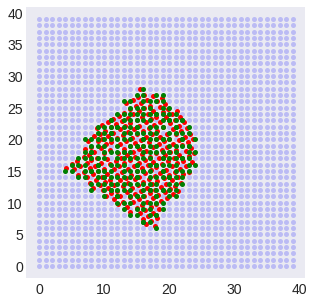

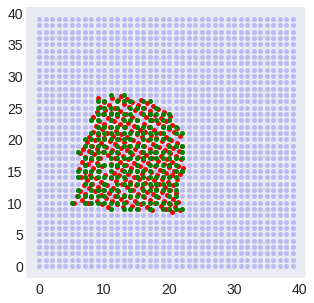

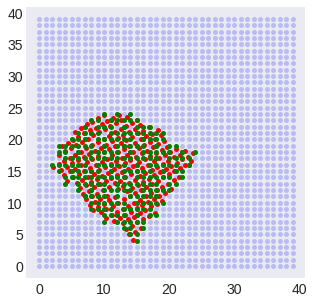

Found 14880 genes among all datasets
[[0.         0.85909091 0.79545455]
 [0.         0.         0.83181818]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9186215375622795

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.511247457589338

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00043542323819451



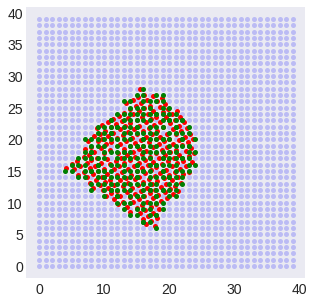

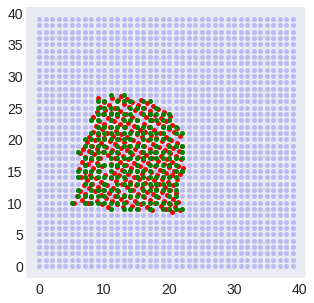

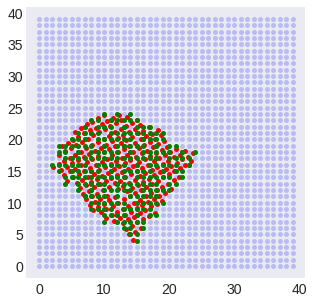

Found 14880 genes among all datasets
[[0.         0.82727273 0.77272727]
 [0.         0.         0.84545455]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.586853100955446

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8582591446694555

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00691208328731252

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006907450808287141

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002459190124641797

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003270601089673475

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00253173224996317

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003420798787140078

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00174429159367262

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0036231373695968516



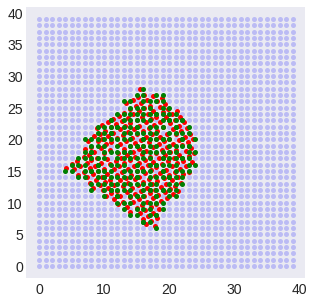

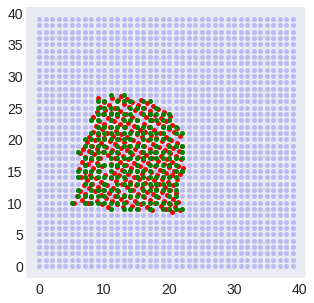

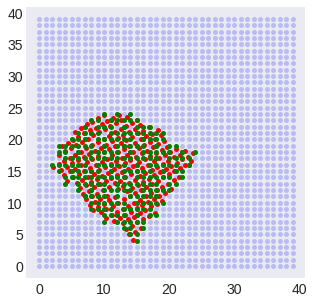

Found 14880 genes among all datasets
[[0.         0.81363636 0.72272727]
 [0.         0.         0.78636364]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.8851054197051367

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9378062934141831

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02323865124623281

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.030227813877756304

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.021934898980030315

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005973950058298039

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008069187242626619

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002276869005203963

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00011168160179031439



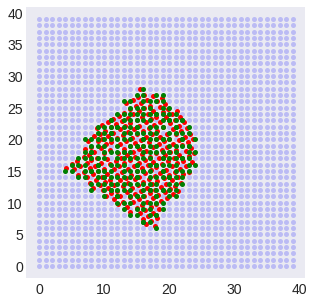

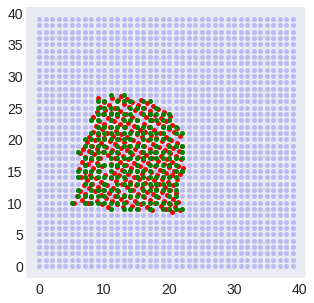

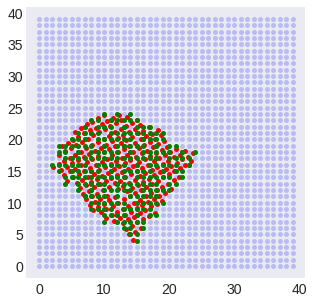

Found 14880 genes among all datasets
[[0.         0.83181818 0.75909091]
 [0.         0.         0.79545455]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6220273080778287

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12691324273930293

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018348945758703827

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003385997248896988

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0006562411301842541



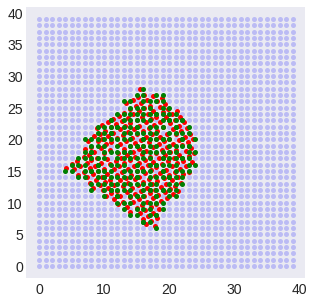

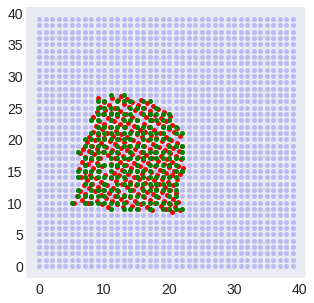

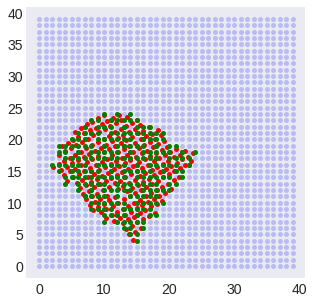

Found 14880 genes among all datasets
[[0.         0.85       0.80454545]
 [0.         0.         0.88181818]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.43474634699007275

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



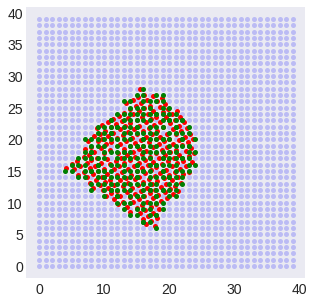

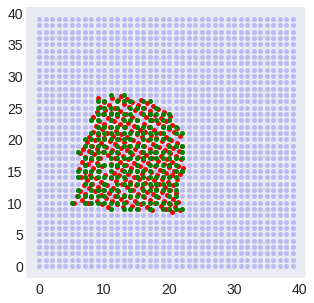

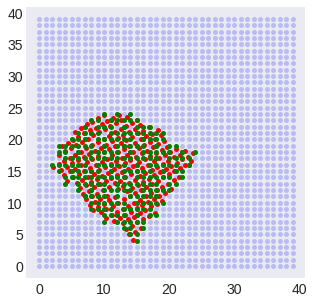

Found 14880 genes among all datasets
[[0.         0.85454545 0.76363636]
 [0.         0.         0.81818182]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004378556330311145



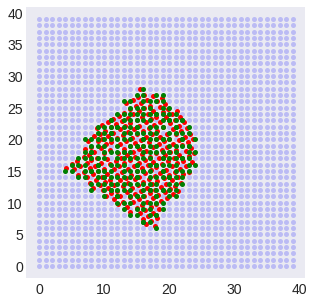

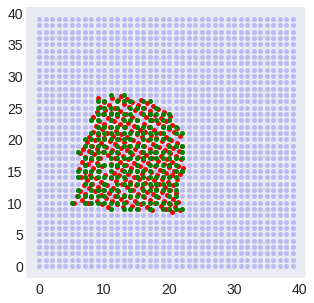

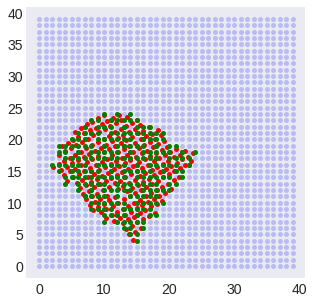

Found 14880 genes among all datasets
[[0.         0.84090909 0.75454545]
 [0.         0.         0.79545455]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9626236552494786

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.5159474167807117

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007569716914653246



/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


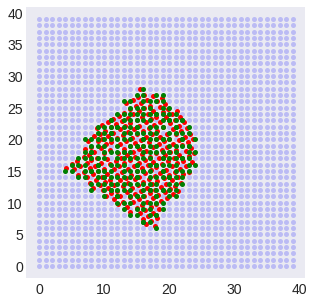

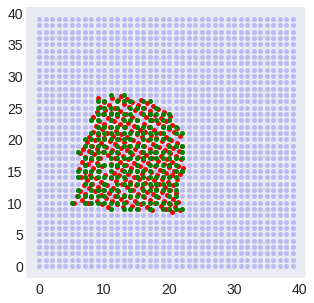

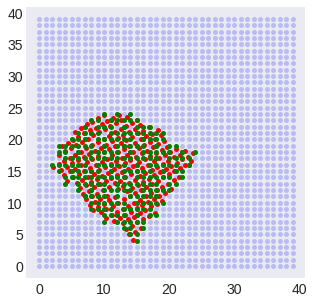

Found 14880 genes among all datasets
[[0.         0.83181818 0.75909091]
 [0.         0.         0.78181818]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6054853962691769

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8787668159793738

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0035161409082986594

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.027116951272239787

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.022072334307983388

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004353831284571563

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00010479770613969208



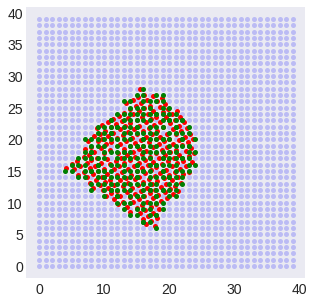

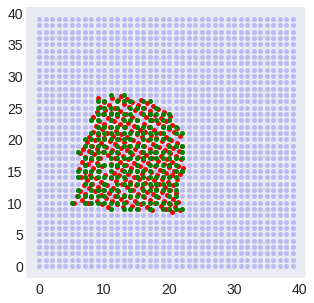

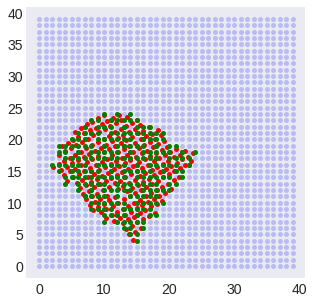

Found 14880 genes among all datasets
[[0.         0.80909091 0.73636364]
 [0.         0.         0.79090909]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.795856343886387

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.03497422944847

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009043466547598022



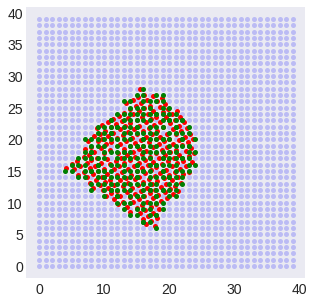

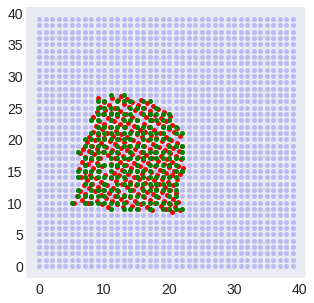

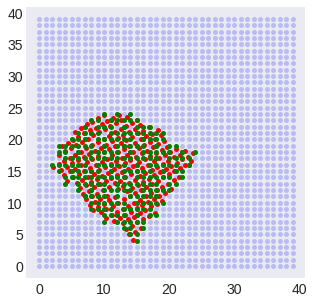

Found 14880 genes among all datasets
[[0.         0.84545455 0.74545455]
 [0.         0.         0.83636364]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6064653528329356

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.13082120860430213

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001077365101955996

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010021533625721446

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 7.897092513253767e-06



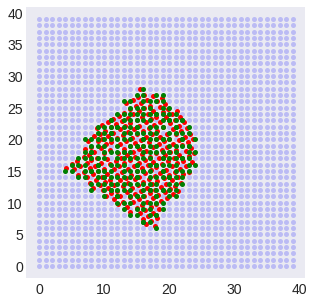

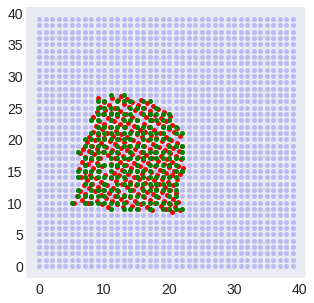

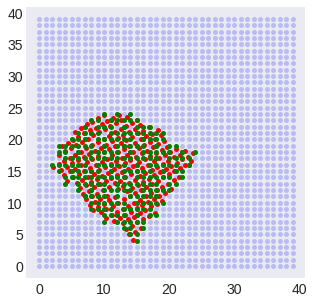

Found 14880 genes among all datasets
[[0.         0.83636364 0.77727273]
 [0.         0.         0.85      ]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.43474634699007275

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



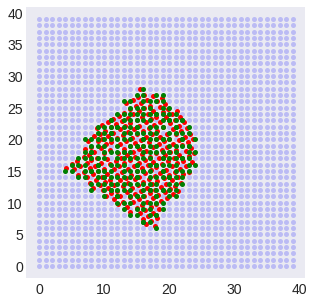

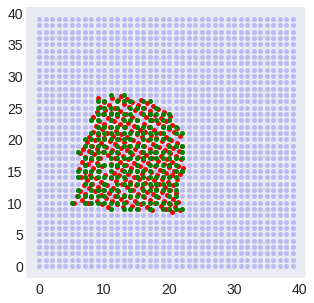

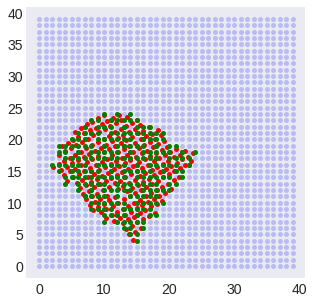

Found 14880 genes among all datasets
[[0.         0.85454545 0.77727273]
 [0.         0.         0.85909091]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.34287135958449055

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.26390299888806035

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009413463505192343



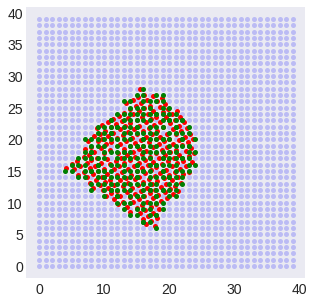

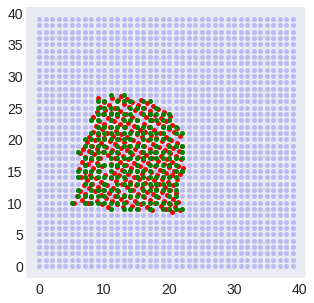

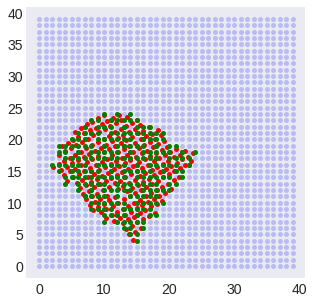

Found 14880 genes among all datasets
[[0.         0.85909091 0.79545455]
 [0.         0.         0.83181818]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9186215375622795

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.511247457589338

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00043542323819451



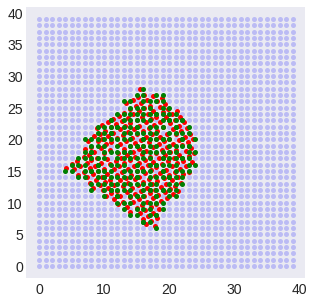

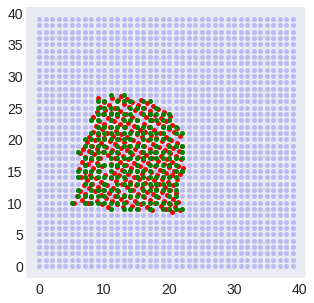

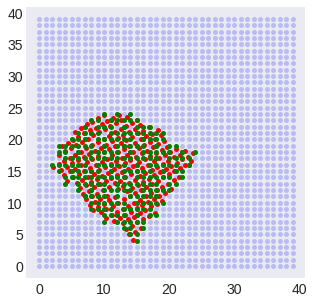

Found 14880 genes among all datasets
[[0.         0.82727273 0.77272727]
 [0.         0.         0.84545455]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.586853100955446

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8582591446694555

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00691208328731252

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006907450808287141

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002459190124641797

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003270601089673475

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00253173224996317

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003420798787140078

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00174429159367262

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0036231373695968516



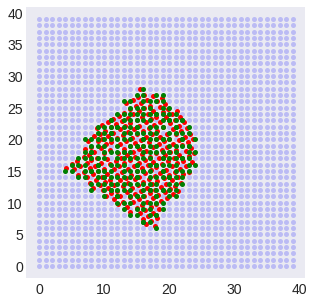

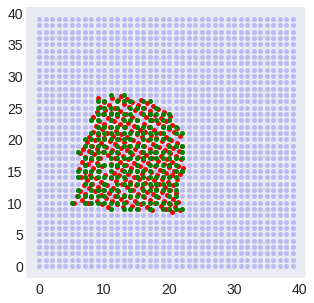

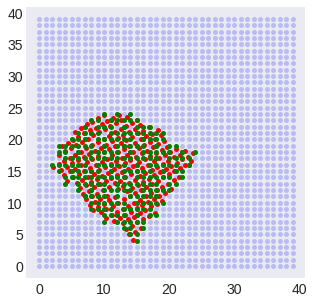

Found 14880 genes among all datasets
[[0.         0.81363636 0.72272727]
 [0.         0.         0.78636364]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.8851054197051367

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9378062934141831

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02323865124623281

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.030227813877756304

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.021934898980030315

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005973950058298039

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008069187242626619

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002276869005203963

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00011168160179031439



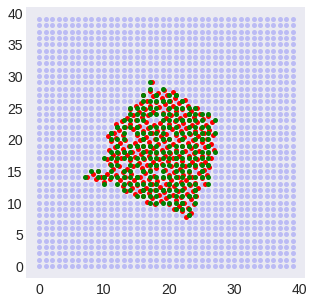

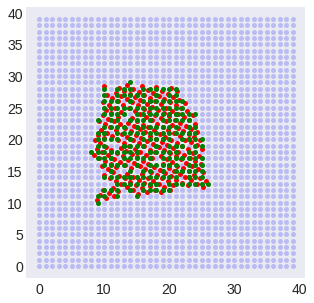

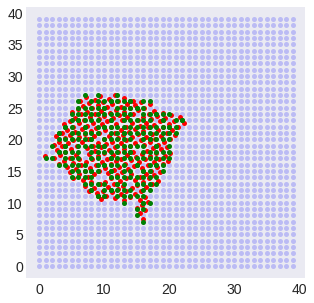

Found 14789 genes among all datasets
[[0.         0.83410138 0.75576037]
 [0.         0.         0.77419355]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.602783671688215

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.1312946106383972

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004516985980927313

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007084264443779631



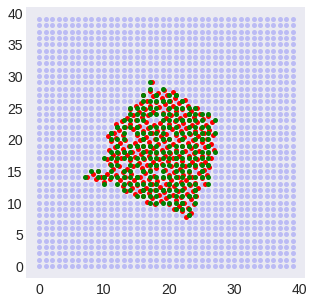

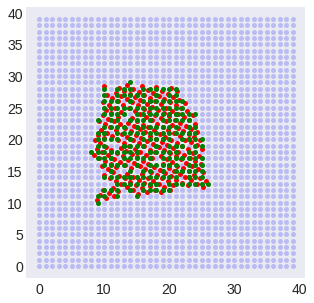

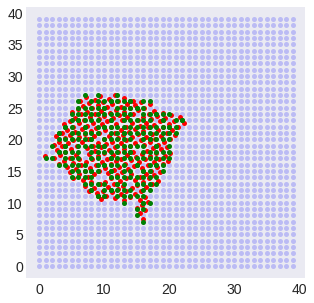

Found 14789 genes among all datasets
[[0.         0.88479263 0.81105991]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.806682669558215

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.2862601528904634e-14



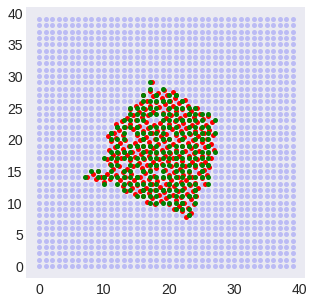

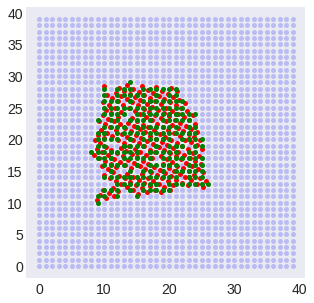

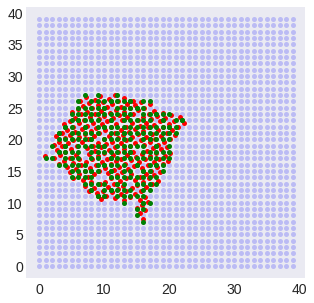

Found 14789 genes among all datasets
[[0.         0.78341014 0.73732719]
 [0.         0.         0.77880184]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7119180521455464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.28254714448356943

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002411461401355952

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003386761718717768

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010924381694518148

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007468452886570387



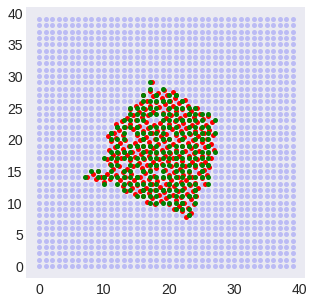

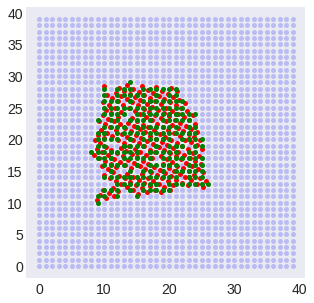

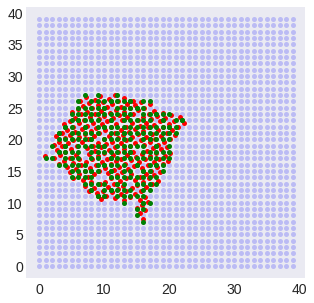

Found 14789 genes among all datasets
[[0.         0.83870968 0.78801843]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.4232210623845205

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.570123516638411

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01044871901763722

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0030976087208925973

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004412863805723477

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.1895934173030724e-06



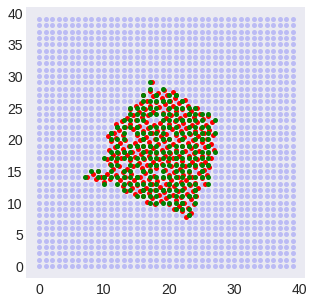

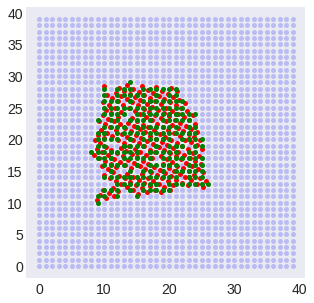

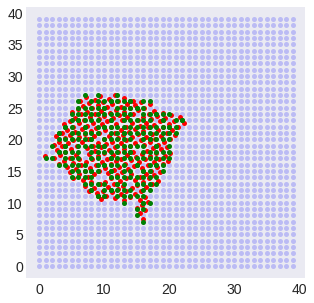

Found 14789 genes among all datasets
[[0.         0.82949309 0.73271889]
 [0.         0.         0.82488479]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.326464210478017

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8765728311939007

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0063797829394731664

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01262171987168692

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004799742138492213

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003954860801846927

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005412944751822302

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0059138826402787

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.013467981958696917

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.012956541223436258



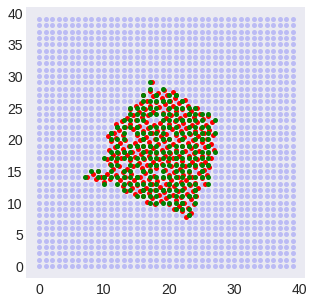

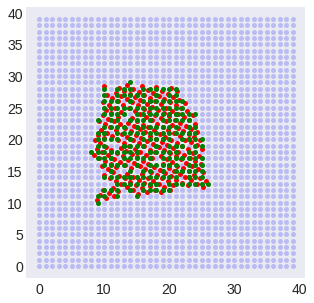

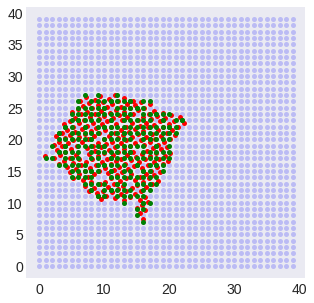

Found 14789 genes among all datasets
[[0.         0.8156682  0.77880184]
 [0.         0.         0.84331797]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.704704257753669

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.2463362794804906

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00825241818585587

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032425793551631443

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017253951209998952

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018248547270554027

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0037152324746849708

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.000567246435372315



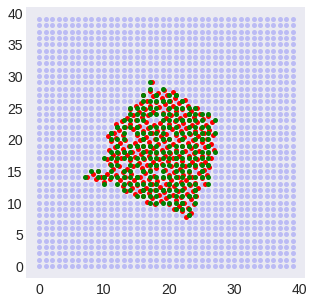

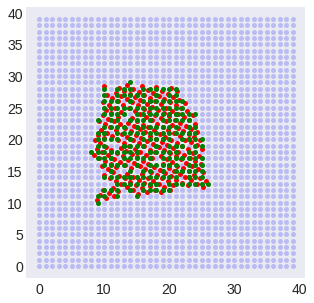

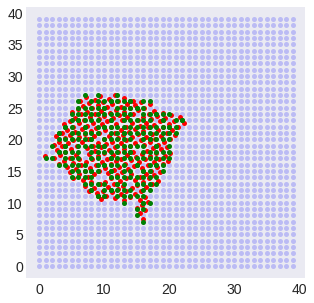

Found 14789 genes among all datasets
[[0.         0.8202765  0.69585253]
 [0.         0.         0.77419355]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6084844773268347

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.13299757173858184

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010094443808574827

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0044326463200743405

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 5.426500708538562e-05



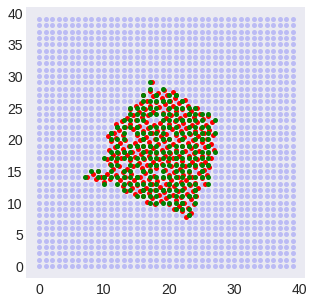

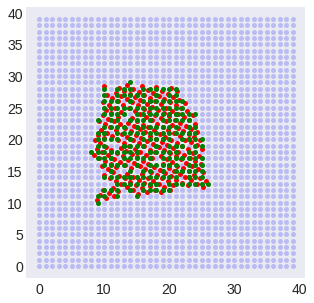

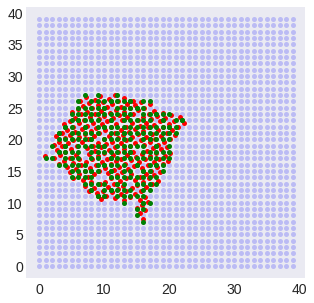

Found 14789 genes among all datasets
[[0.         0.8202765  0.74193548]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.806682669558215

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.2862601528904634e-14



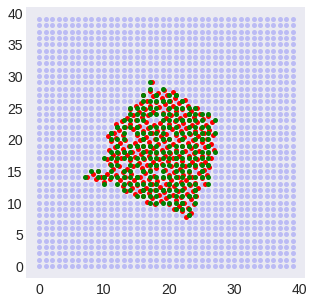

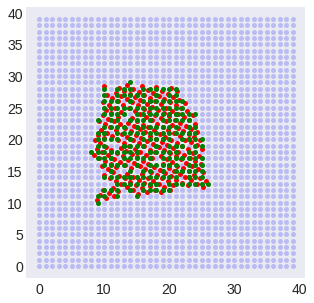

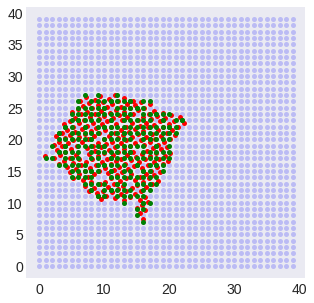

Found 14789 genes among all datasets
[[0.         0.81105991 0.75115207]
 [0.         0.         0.79723502]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.510347283138051

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2708849922874914

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0013463975177750442

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032035637396163885

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0031505154590304174

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00031418790822068665



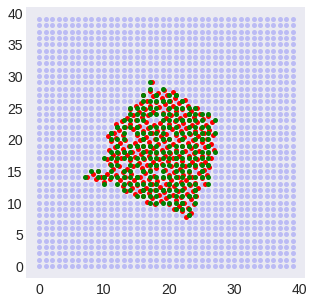

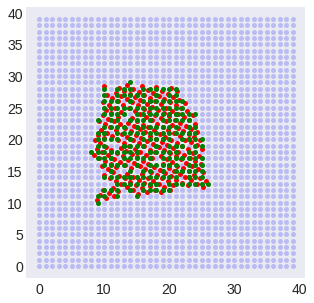

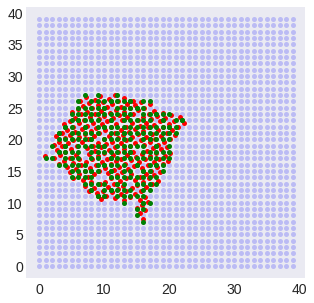

Found 14789 genes among all datasets
[[0.         0.83870968 0.74654378]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.0244896992772006

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.586206736455829

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006209626656986211

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018077937372029673

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008373807147392665



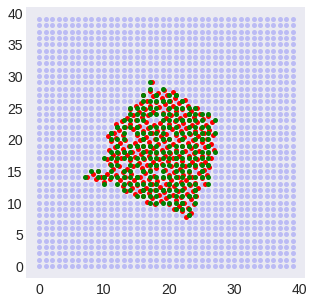

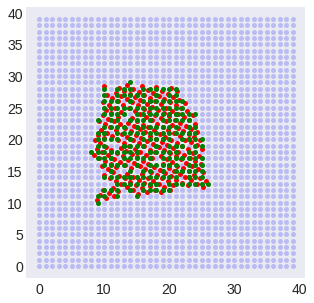

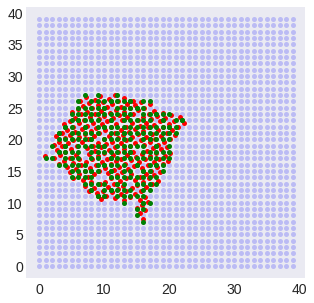

Found 14789 genes among all datasets
[[0.         0.77880184 0.70967742]
 [0.         0.         0.82488479]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.491615061906371

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7952692761179498

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02200631889372695

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002947605963992128

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021934360541933096

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004600113456529442

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021818943798490587

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0029141696407033457

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021147877219256372

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003119326391741062



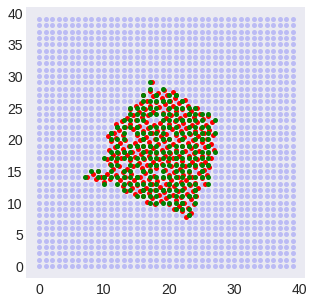

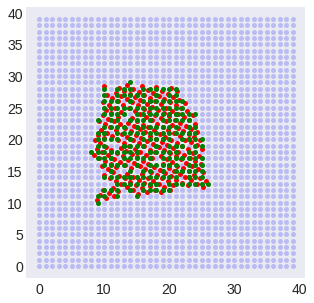

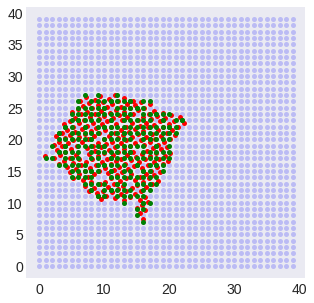

Found 14789 genes among all datasets
[[0.         0.8156682  0.77880184]
 [0.         0.         0.84331797]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.704704257753669

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.2463362794804906

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00825241818585587

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032425793551631443

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017253951209998952

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018248547270554027

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0037152324746849708

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.000567246435372315



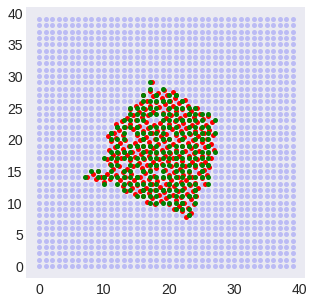

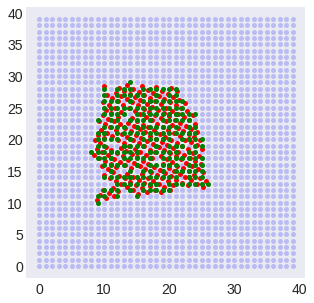

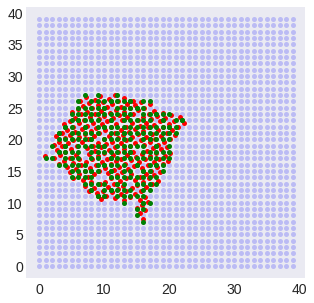

Found 14789 genes among all datasets
[[0.         0.8202765  0.69585253]
 [0.         0.         0.77419355]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6084844773268347

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.13299757173858184

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010094443808574827

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0044326463200743405

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 5.426500708538562e-05



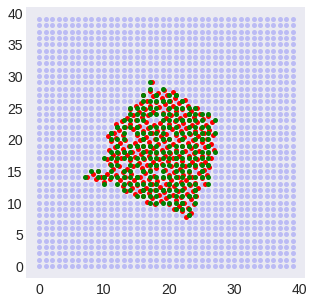

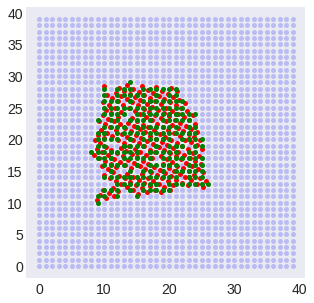

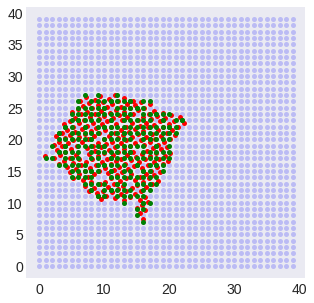

Found 14789 genes among all datasets
[[0.         0.8202765  0.74193548]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.806682669558215

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.2862601528904634e-14



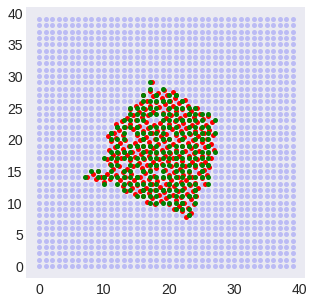

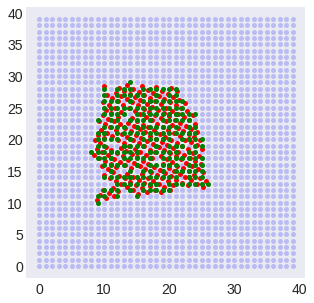

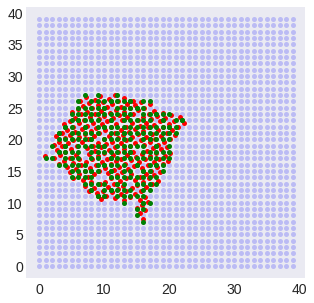

Found 14789 genes among all datasets
[[0.         0.81105991 0.75115207]
 [0.         0.         0.79723502]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.510347283138051

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2708849922874914

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0013463975177750442

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032035637396163885

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0031505154590304174

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00031418790822068665



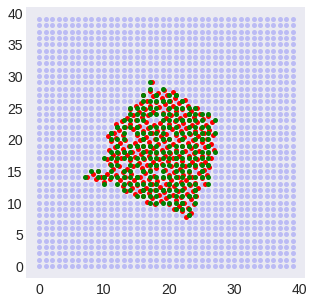

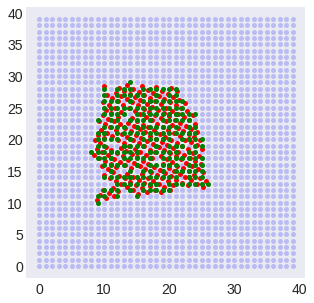

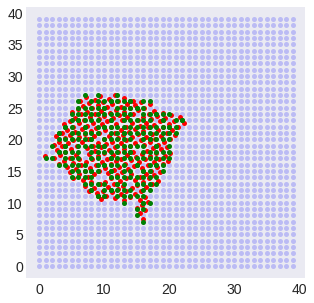

Found 14789 genes among all datasets
[[0.         0.83870968 0.74654378]
 [0.         0.         0.8156682 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.0244896992772006

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.586206736455829

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006209626656986211

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018077937372029673

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008373807147392665



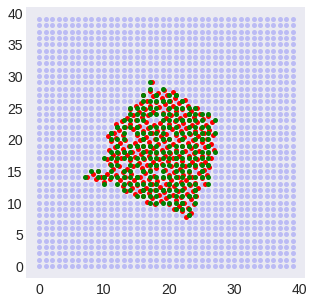

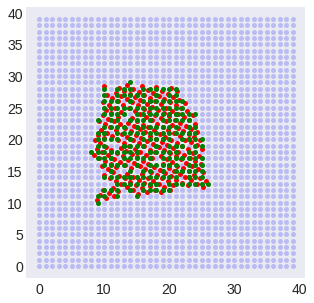

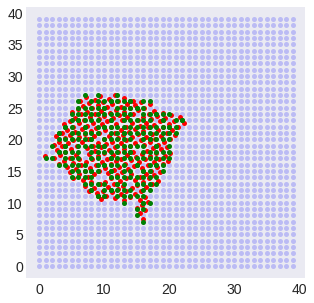

Found 14789 genes among all datasets
[[0.         0.77880184 0.70967742]
 [0.         0.         0.82488479]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.491615061906371

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7952692761179498

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02200631889372695

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002947605963992128

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021934360541933096

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004600113456529442

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021818943798490587

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0029141696407033457

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021147877219256372

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003119326391741062



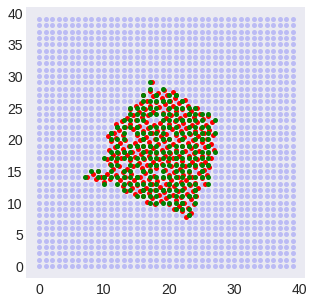

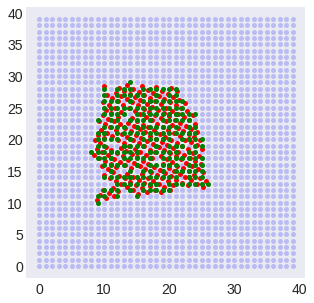

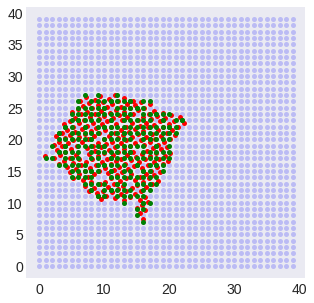

Found 14789 genes among all datasets
[[0.         0.8156682  0.77880184]
 [0.         0.         0.84331797]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.704704257753669

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.2463362794804906

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00825241818585587

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032425793551631443

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017253951209998952

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018248547270554027

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0037152324746849708

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.000567246435372315



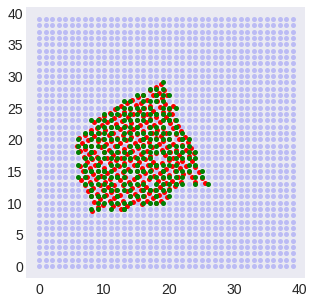

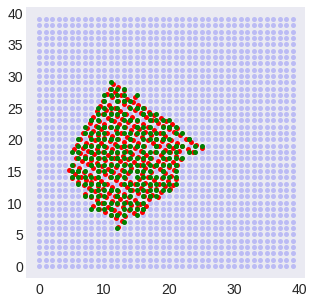

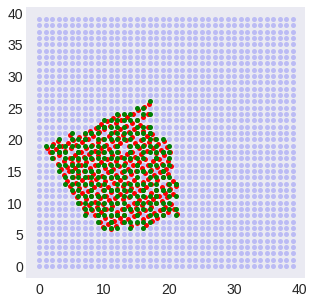

Found 14929 genes among all datasets
[[0.         0.83478261 0.76956522]
 [0.         0.         0.85652174]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5774476114071962

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12278862435838622

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009089847086940495



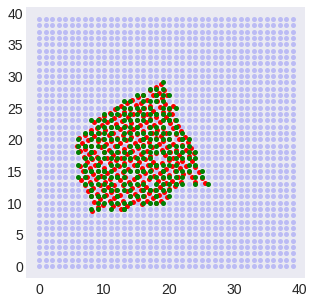

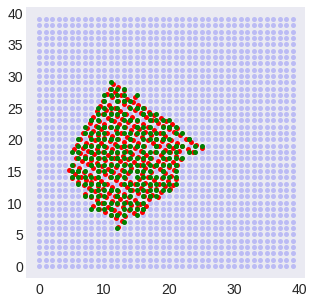

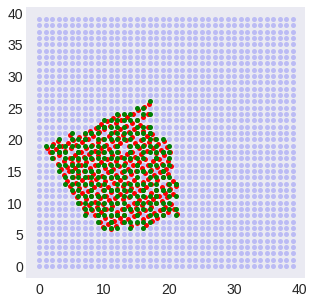

Found 14929 genes among all datasets
[[0.         0.84140969 0.77391304]
 [0.         0.         0.8061674 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



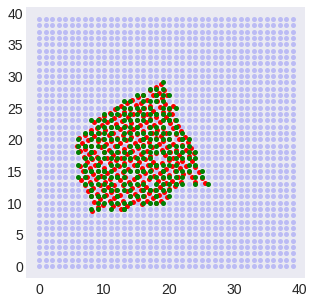

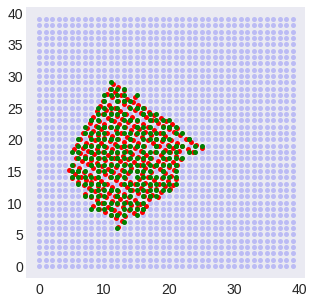

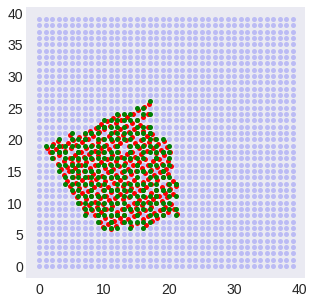

Found 14929 genes among all datasets
[[0.         0.84782609 0.7826087 ]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.1628088651398137

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.17893858862008938

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011867661559570114

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.1717701983967626e-05



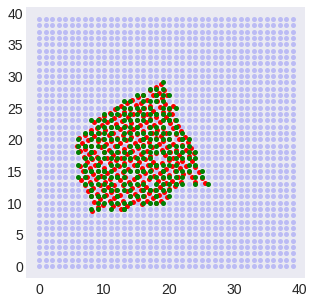

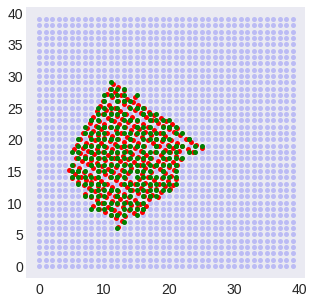

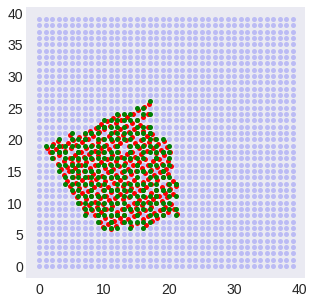

Found 14929 genes among all datasets
[[0.         0.83913043 0.76086957]
 [0.         0.         0.83478261]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.7254133052261993

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.5118564593444288

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006427009133625816

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004350029385432608

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008429338876600356

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0002850068097477454



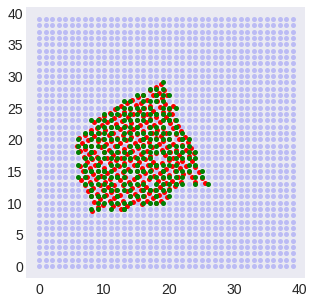

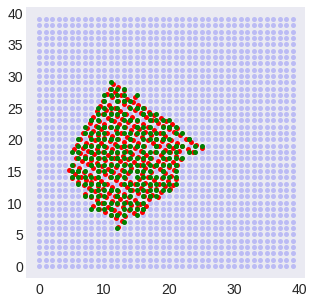

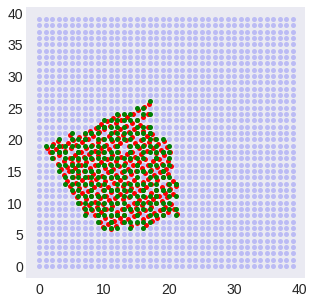

Found 14929 genes among all datasets
[[0.         0.79130435 0.72173913]
 [0.         0.         0.8       ]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.3817002760465624

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7108992167176376

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018078203329603415

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003025678361404882

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00036937629465993993



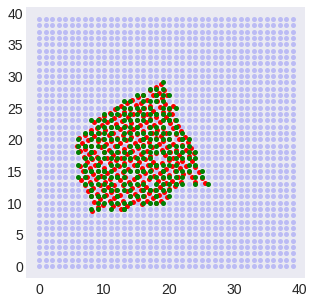

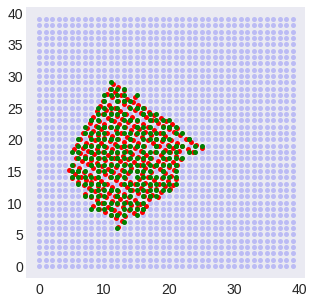

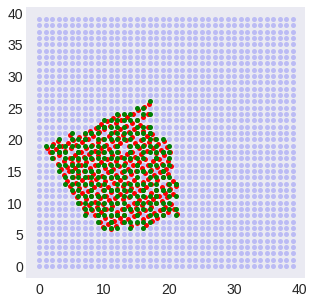

Found 14929 genes among all datasets
[[0.         0.83043478 0.78695652]
 [0.         0.         0.85652174]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.7803151739487617

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.0242786950819425

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006994663605827567

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017115509162339837

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0016959090348880324

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0011265817472301265

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008644774938252331



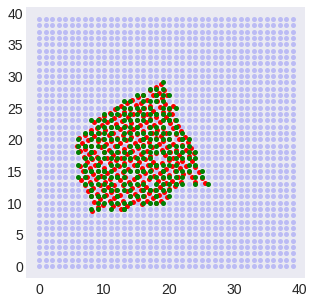

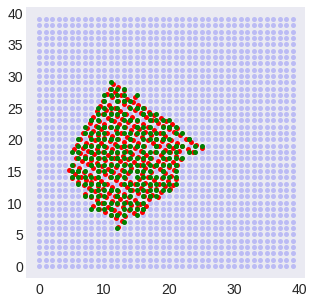

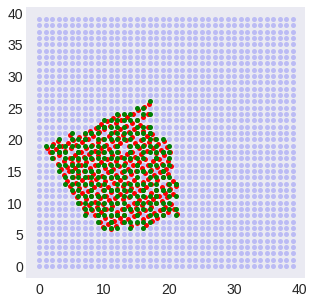

Found 14929 genes among all datasets
[[0.         0.81304348 0.77391304]
 [0.         0.         0.83043478]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5726269355082003

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12731511323617806

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002762828358524594

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010247318520171245

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00038582705229317504



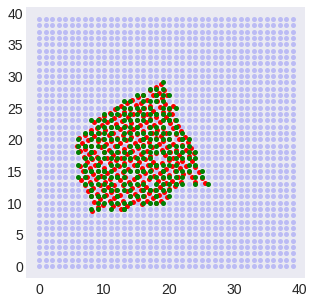

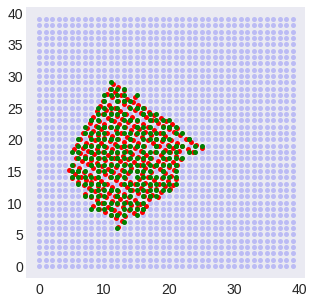

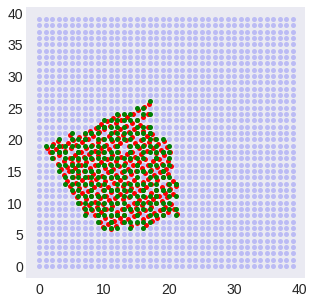

Found 14929 genes among all datasets
[[0.         0.80869565 0.7826087 ]
 [0.         0.         0.83913043]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



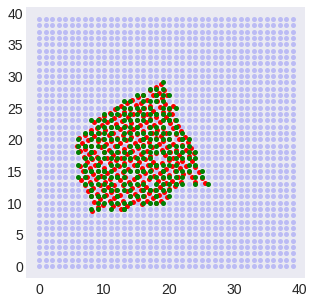

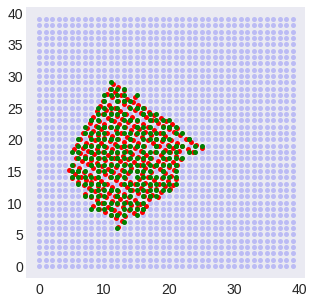

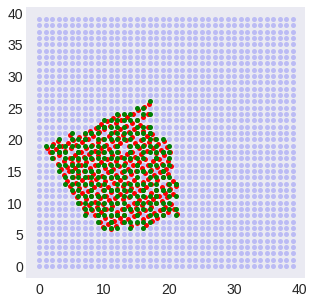

Found 14929 genes among all datasets
[[0.         0.83913043 0.76956522]
 [0.         0.         0.80176211]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.20555838346297173

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.20992741971444473

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006063621007338649

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0012821156946737355

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0014543490063930187

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010596544822616405

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00017107598967214255



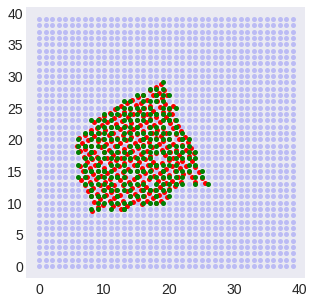

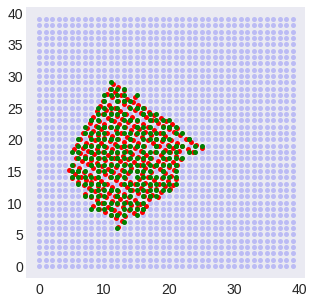

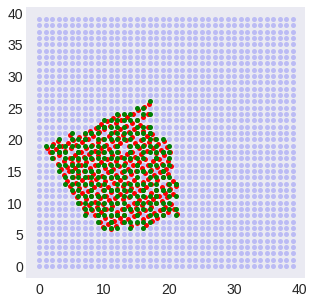

Found 14929 genes among all datasets
[[0.         0.85652174 0.75217391]
 [0.         0.         0.84581498]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7966938790077704

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.45229802981899486

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0050807331133505

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0020161780111663807

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007375952657795448



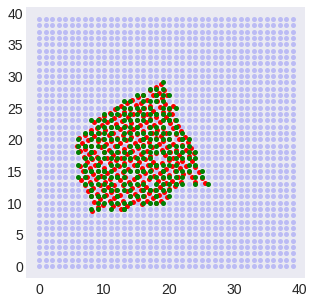

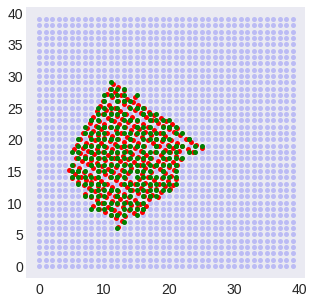

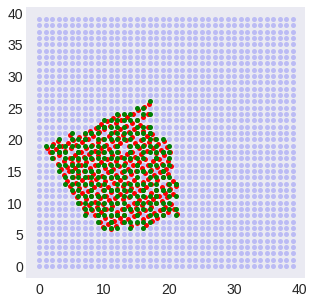

Found 14929 genes among all datasets
[[0.         0.83259912 0.7826087 ]
 [0.         0.         0.83913043]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.9727869352620813

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7764838547856128

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011885394822515938

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0038494741642751684

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003351942459906443

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00836901314466898

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008254383161037993

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004931983337300494

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00647615006561697

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004504578959691585



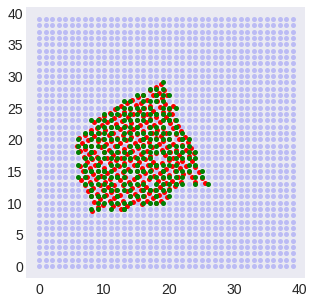

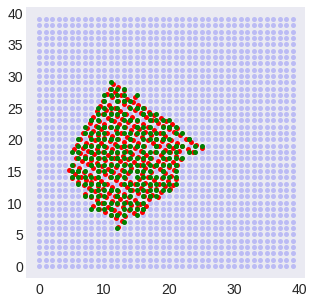

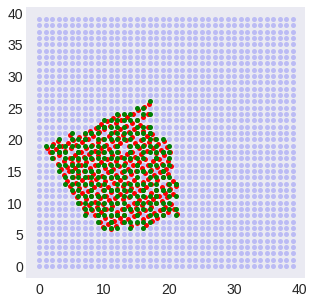

Found 14929 genes among all datasets
[[0.         0.89130435 0.8       ]
 [0.         0.         0.83913043]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.5630077376735736

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9516873744351642

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0026281679625965726

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010938502446589116

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003492344344696141

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0075053418558415075

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002689551073269847

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004176232421287729

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.007510423245612019

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004204516579389361



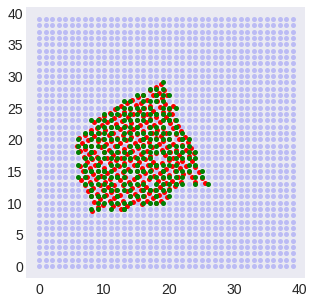

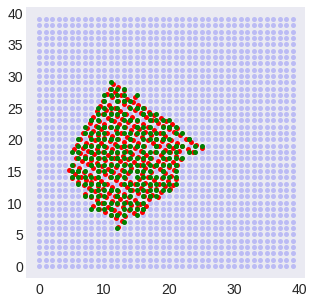

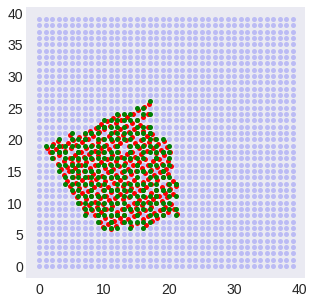

Found 14929 genes among all datasets
[[0.         0.88695652 0.77826087]
 [0.         0.         0.83043478]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5457618637508466

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.11455268228332605

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0035863101074211645

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0013052019029875517

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0016545770599623033

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00035764665889836955



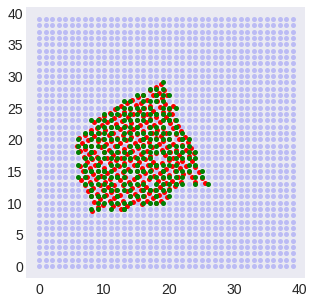

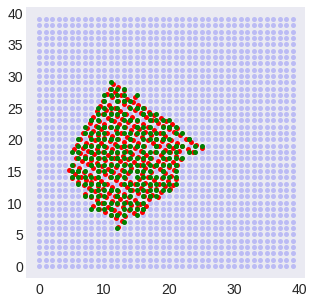

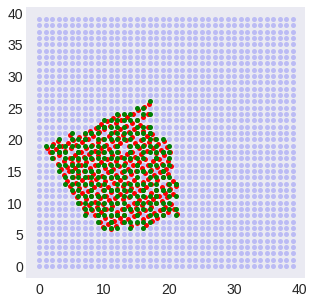

Found 14929 genes among all datasets
[[0.         0.81304348 0.77391304]
 [0.         0.         0.83478261]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



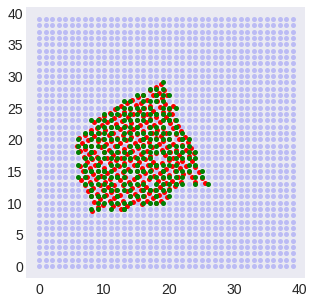

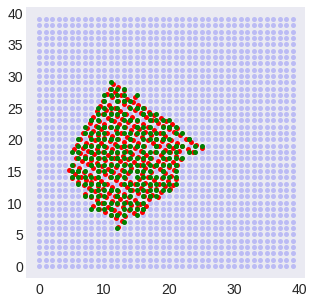

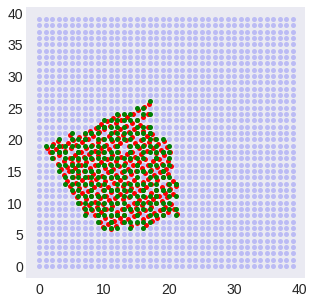

Found 14929 genes among all datasets
[[0.         0.82608696 0.82173913]
 [0.         0.         0.87826087]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2336800663378118

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.20169989255509307

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.014105060421227764

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0006694682292699983



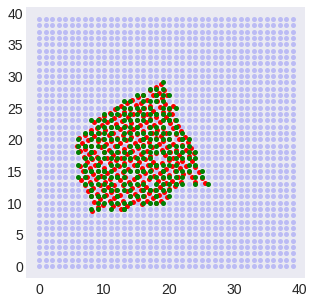

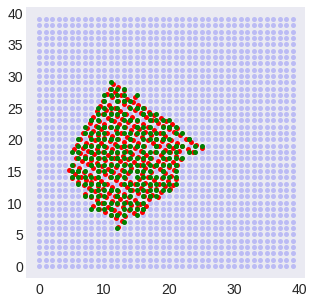

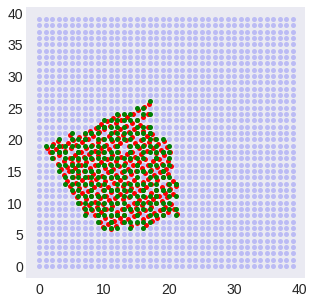

Found 14929 genes among all datasets
[[0.         0.85217391 0.7826087 ]
 [0.         0.         0.80869565]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.3101068555152577

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.4476740118115238

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010461983861830282

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0019461761050741933

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0006049732268547103



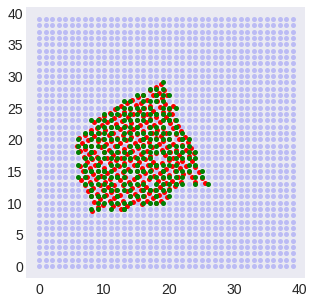

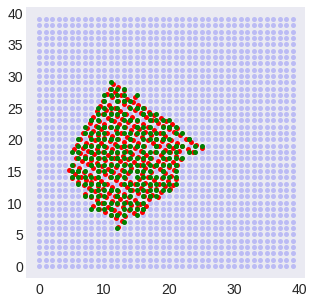

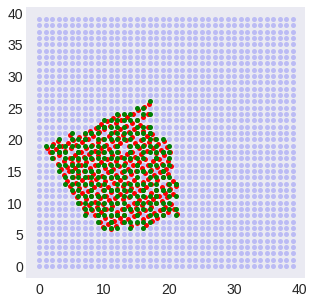

Found 14929 genes among all datasets
[[0.         0.84782609 0.8       ]
 [0.         0.         0.86521739]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.100800119124857

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7611397631655317

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001632715382062222

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002491957933040745

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00041328735650364434



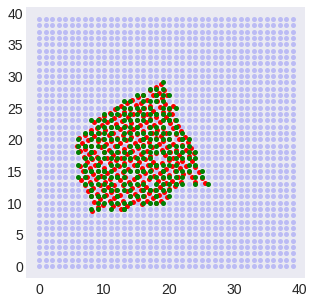

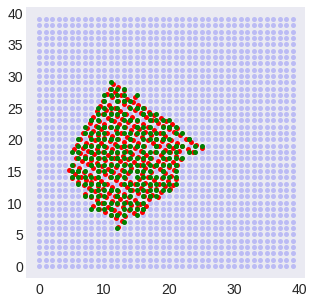

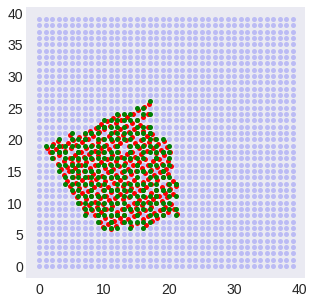

Found 14929 genes among all datasets
[[0.         0.85652174 0.77391304]
 [0.         0.         0.83043478]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.107952572786218

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9675902034723838

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005075827035498026

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01637951983547037

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01625113256513222

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006529999215760807

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0003148324164343741



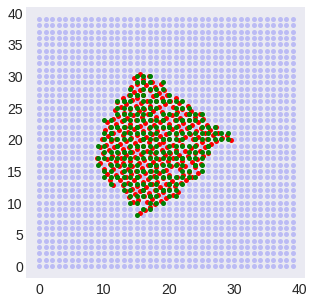

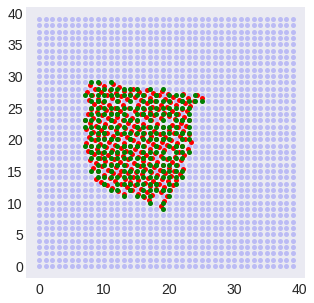

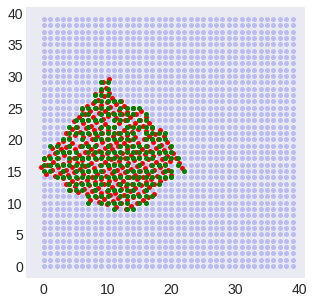

Found 14808 genes among all datasets
[[0.         0.84415584 0.76623377]
 [0.         0.         0.80519481]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.3946249812387292

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.09757422337347466

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018057150334829242

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00011478224370020662



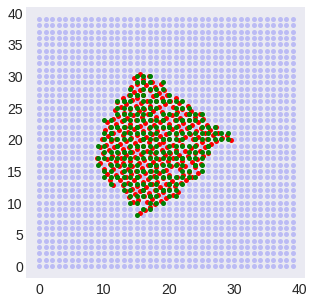

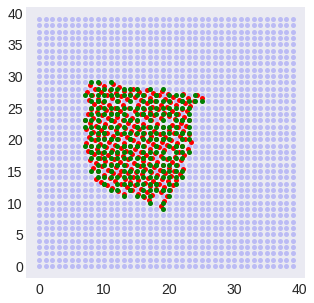

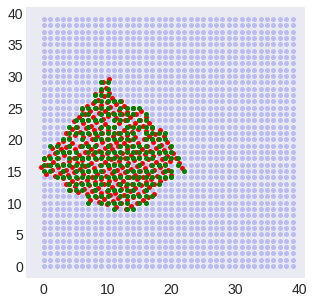

Found 14808 genes among all datasets
[[0.         0.83549784 0.75757576]
 [0.         0.         0.81385281]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.34367423569394134

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



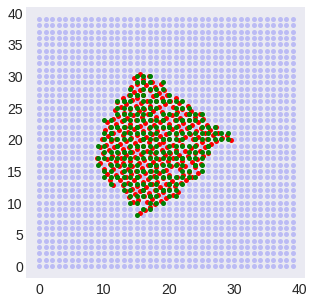

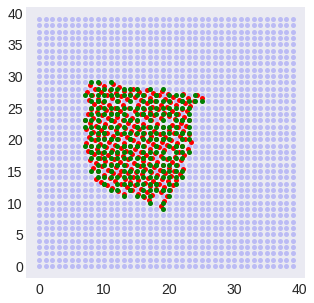

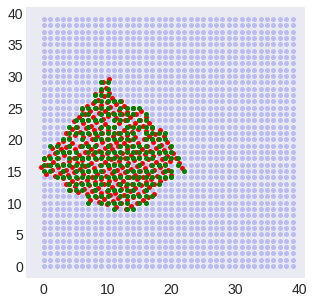

Found 14808 genes among all datasets
[[0.         0.82683983 0.75757576]
 [0.         0.         0.84415584]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6263388880680243

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.21225330710682566

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0018578141731765418

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002170273186452465

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0025764016599341133

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004390021677388889

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0023107927607324275

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0016982104784409868

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0005056402029571805



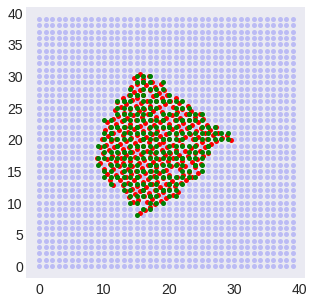

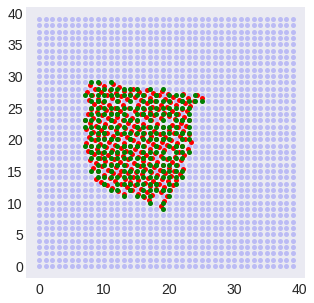

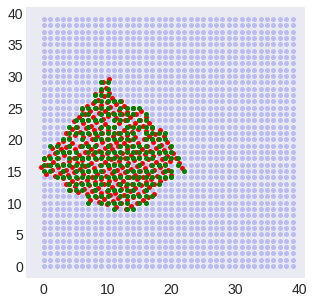

Found 14808 genes among all datasets
[[0.         0.8961039  0.80952381]
 [0.         0.         0.8008658 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.40652754295721355

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.4416756302444132

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0014133282457741703

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001765550447881653

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004991929519137045

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0038480417800210442

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001753143911005478

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006791685382404072

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.007164855618806726

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00735032194670443



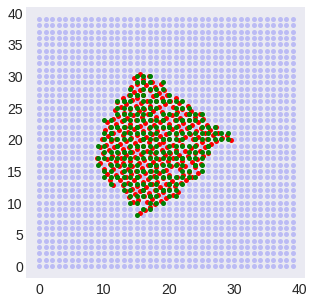

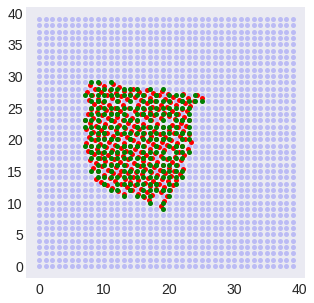

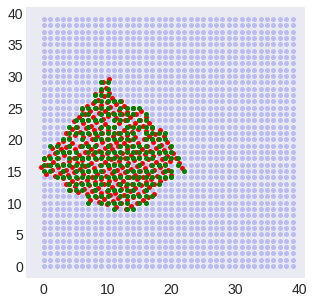

Found 14808 genes among all datasets
[[0.         0.85281385 0.81385281]
 [0.         0.         0.86147186]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.203810702929354

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7489860414615741

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008532624415933387



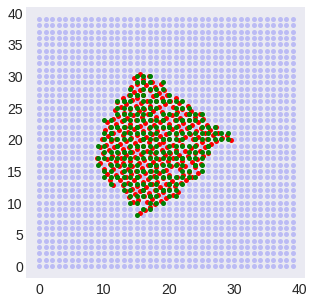

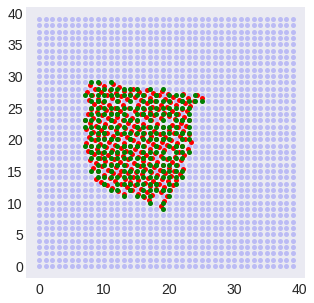

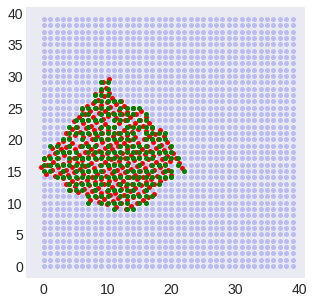

Found 14808 genes among all datasets
[[0.         0.81818182 0.74025974]
 [0.         0.         0.77489177]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.9197828154349756

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9154065151706767

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01007124572217677

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005562391318948201

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009485244656267877

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.012381350373278366

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032794630371482114

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005706047739358677

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002113584438243832

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002852500073576403



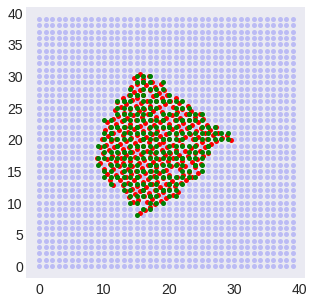

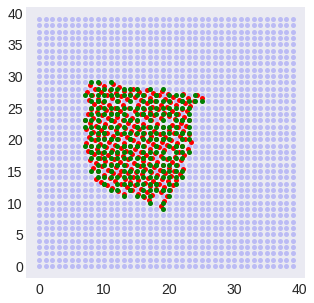

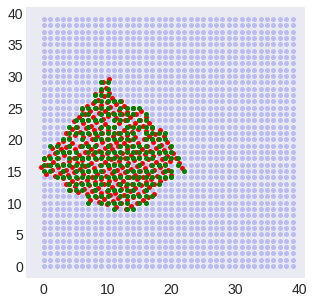

Found 14808 genes among all datasets
[[0.         0.83982684 0.80519481]
 [0.         0.         0.86580087]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.4346925711041252

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.09361497660107254

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008636760794684673



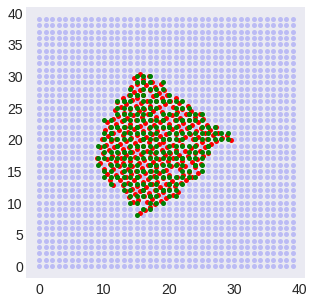

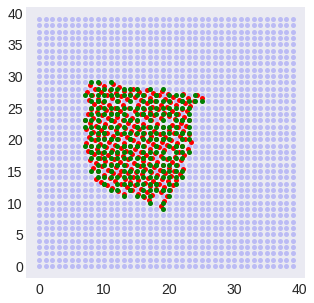

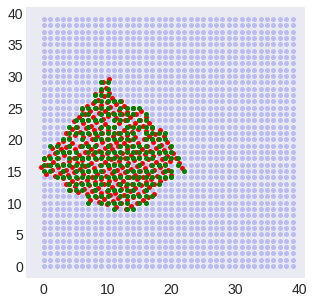

Found 14808 genes among all datasets
[[0.         0.83549784 0.76190476]
 [0.         0.         0.8008658 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.34367423569394134

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



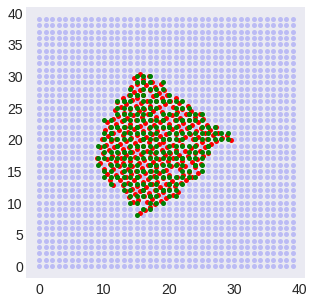

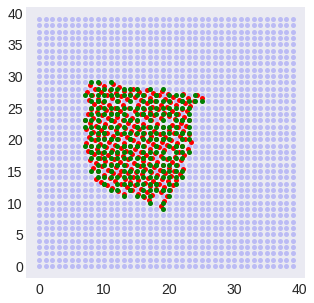

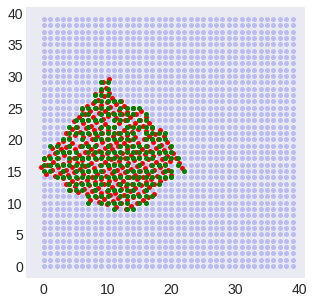

Found 14808 genes among all datasets
[[0.         0.79220779 0.72727273]
 [0.         0.         0.83116883]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.1399020929421586

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.21889894525116924

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00458694179840223

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006317618271223305

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005397139074284643

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0033379761409998293

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002226164688955437

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0022260309750678636

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0021945770124808806

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0023936291179775387



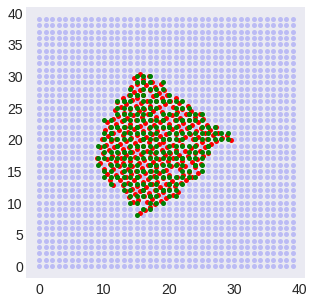

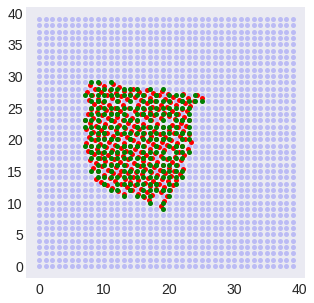

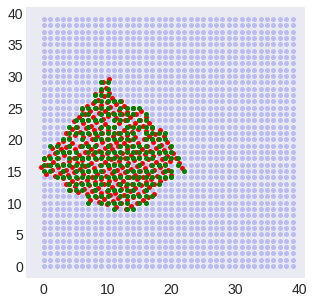

Found 14808 genes among all datasets
[[0.         0.88311688 0.83982684]
 [0.         0.         0.86580087]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.4117563002739808

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.44987080392533474

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0015371769919776401

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017228030866965893

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00315760274676391

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0025267945662226232

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0027060785221639794

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0002981503049893641



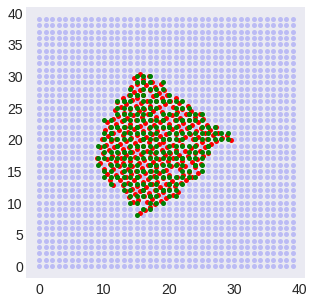

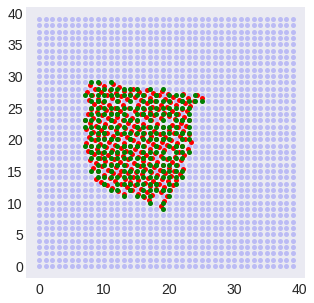

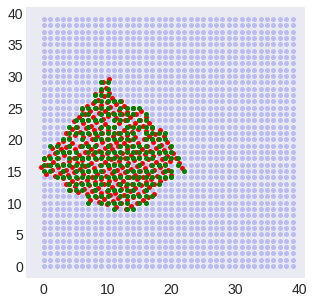

Found 14808 genes among all datasets
[[0.         0.8008658  0.76623377]
 [0.         0.         0.83549784]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.0820160013927367

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6486834626151974

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005161040737682587

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0015947296461801264

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009722281493519336

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0015918077783334539

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0023552964867386006

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00907946049937236

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011405762015231136

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008013486835611483



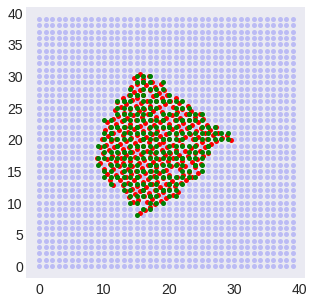

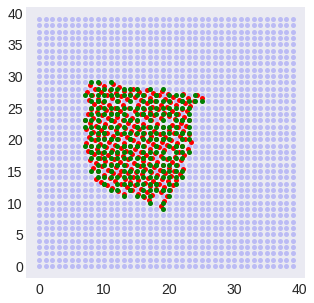

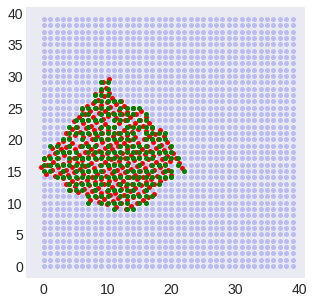

Found 14808 genes among all datasets
[[0.         0.87012987 0.8008658 ]
 [0.         0.         0.87878788]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.9629184863697047

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9970372842304238

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0065890476363539285

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005953310934445621

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001224053018671345

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0013728766285951988

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002829383192994639

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009894578795868192



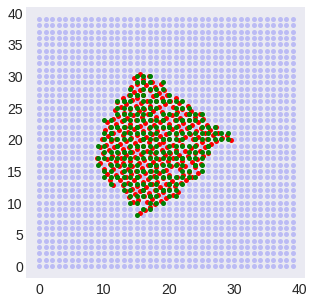

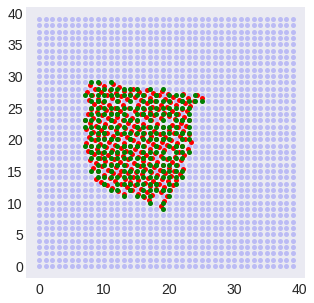

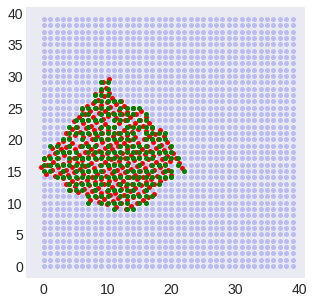

Found 14808 genes among all datasets
[[0.         0.82251082 0.77489177]
 [0.         0.         0.84415584]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.3942331967404287

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.09642354314831292

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 4.94018421950404e-05



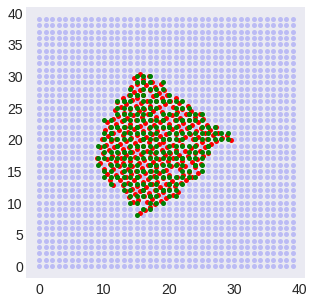

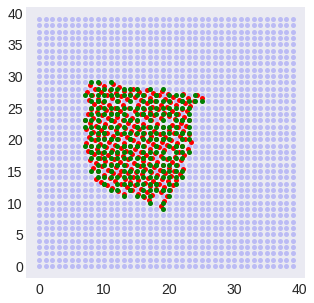

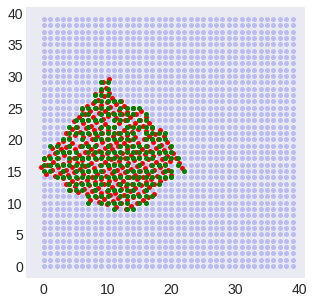

Found 14808 genes among all datasets
[[0.         0.84848485 0.78354978]
 [0.         0.         0.86147186]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.34367423569394134

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0



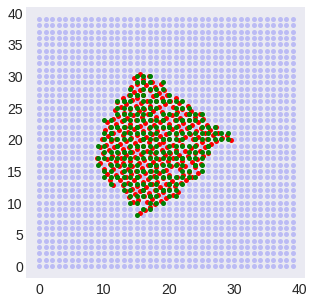

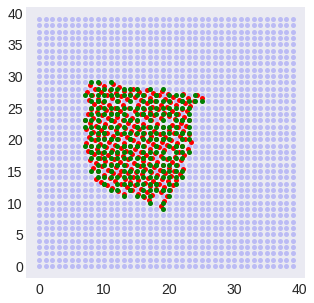

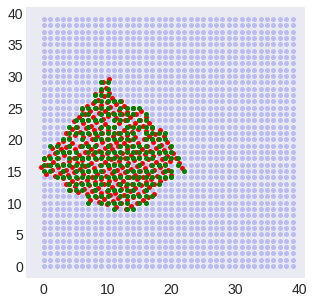

Found 14808 genes among all datasets
[[0.         0.85281385 0.80952381]
 [0.         0.         0.83116883]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6965630487292137

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2488405609062424

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0026947167837523267

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.000628325747734304



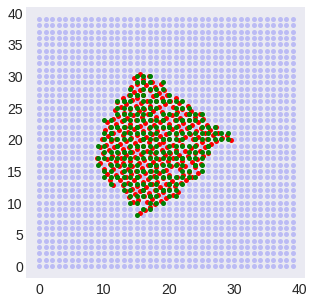

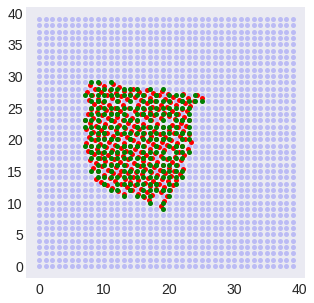

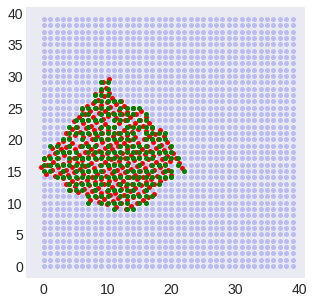

Found 14808 genes among all datasets
[[0.         0.85714286 0.78787879]
 [0.         0.         0.81818182]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.8113471835360904

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.5172676668807976

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004573227946653269

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003927038056551702

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006007767876706316

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004542270430964335

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005368229318901019

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0014182256323855835

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0014793601764708786

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003710972748419694



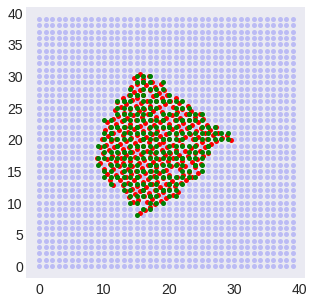

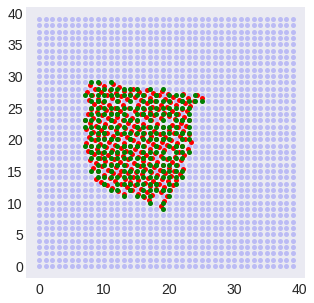

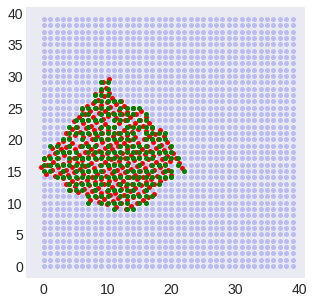

Found 14808 genes among all datasets
[[0.         0.80952381 0.78787879]
 [0.         0.         0.85714286]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.9385117401953083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7363603620241759

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0011095848628439597

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0011007525973534271

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0006652672466573861



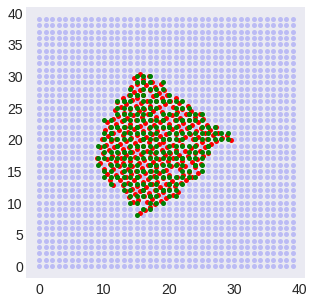

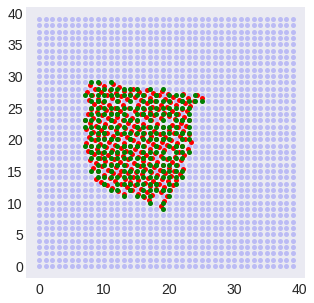

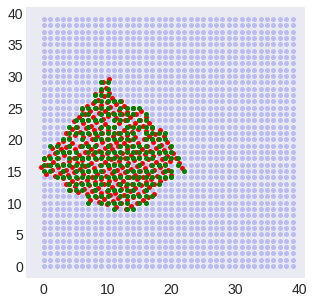

Found 14808 genes among all datasets
[[0.         0.86580087 0.80519481]
 [0.         0.         0.86147186]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.7547107271455893

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.800002581571073

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005861306224089646

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.020099205162280143

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.007457942828167474

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009033947884960702

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004076570594306994

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0052904949669377865

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0015310569585653688

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.002335302683904694



/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [11]:
for slice_name, adata in slices.items():
    paste_results = []
    scanorama_results = []
    for i in range(N_RUNS):
        paste_1 = []
        scanorama_1 = []
        for p in pseudocounts:
            s, p = sim(adata, 0.1, p)
            paste_1.append(p)
            scanorama_1.append(s)
        paste_results.append(paste_1)
        scanorama_results.append(scanorama_1)
    df = pd.DataFrame()
    df['paste'] = np.mean(paste_results, axis = 0)
    df['scanorama'] = np.mean(scanorama_results, axis = 0)
    df.index = pseudocounts
    df.to_csv(path_to_output_dir + slice_name + '.csv')

## Plot results

In [2]:
path_to_output_dir = '../data/Stahl-BC/cached-results/center-sim/scanorama-comparison/'

result_dfs = {}
for slice_name in ['SliceA', 'SliceB', 'SliceC', 'SliceD']:
    df = pd.read_csv(path_to_output_dir + slice_name + '.csv', index_col = 0)
    result_dfs[slice_name] = df

Slice B

C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[(0.0, 280.0)]

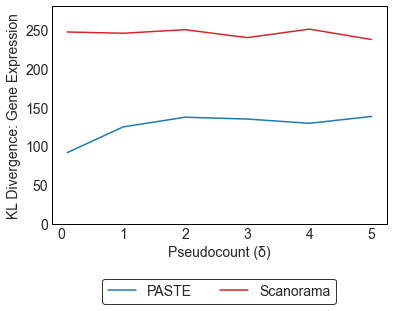

In [3]:
df = result_dfs['SliceB']
x = df.index
ax = sns.lineplot(x, df['paste'], label = "PASTE")
ax = sns.lineplot(x, df['scanorama'], label = "Scanorama", color = '#d62728')
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_title("", fontsize = 14)
ax.set_xlabel('Pseudocount (δ)', fontsize = 14)
ax.set_ylabel('KL Divergence: Gene Expression', fontsize = 14)
ax.legend(loc= 'lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, frameon=True, edgecolor='black', facecolor='white', fontsize=14)
ax.set(ylim = (0, 280))

## All Slices

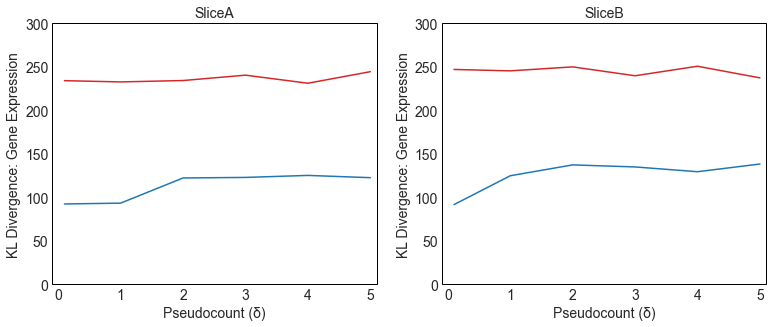

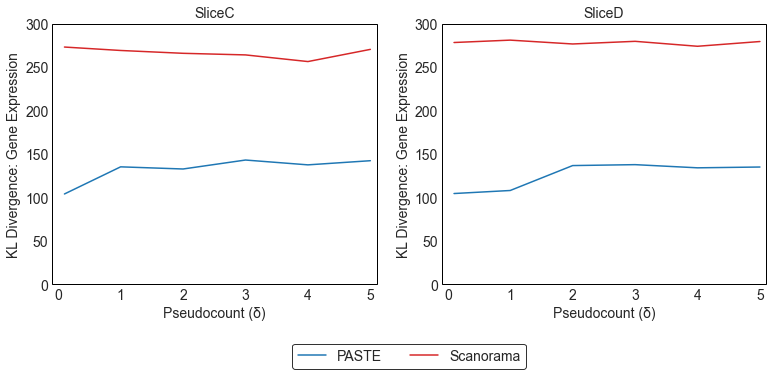

In [4]:
f, ax = plt.subplots(1,2, figsize=(12.8, 4.8))
f1, ax1 = plt.subplots(1,2, figsize=(12.8, 4.8))
# Setting the values for all axes.
plt.setp(ax, xlim=(-0.1,5.1), ylim=(-0.05,1.05))

for a, s in zip([ax[0], ax[1], ax1[0], ax1[1]],  result_dfs.keys()):
    df = result_dfs[s]
    a.plot(df.index, df['paste'], label = "PASTE")
    a.plot(df.index, df['scanorama'], label = "Scanorama", c = '#d62728')
    a.set_title(s, fontsize = 14)

for i in range(2):
    ax[i].set_facecolor('white')
    ax[i].patch.set_edgecolor('black')
    ax[i].patch.set_linewidth('1')  
    ax[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax[i].set_ylabel('KL Divergence: Gene Expression', fontsize = 14)
    ax[i].set(xlim=(-0.1,5.1), ylim = (0, 300))

    
    ax1[i].set(xlim=(-0.1, 5.1), ylim = (0,300))
    ax1[i].set_facecolor('white')
    ax1[i].patch.set_edgecolor('black')
    ax1[i].patch.set_linewidth('1')  
    ax1[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax1[i].set_ylabel('KL Divergence: Gene Expression', fontsize = 14)

handles, labels = ax[1].get_legend_handles_labels()
ax1[1].legend(handles, labels, loc = 'lower center', bbox_to_anchor=(-0.1, -0.35), frameon=True, edgecolor='black', facecolor='white', ncol=4, fontsize=14)
plt.show()